# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [4]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pyspark

In [5]:
app_name = "FinalProject"
sc.stop()
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'), 
                                   ('spark.executor.cores', '4'), 
                                   ('spark.cores.max', '24'), 
                                   ('spark.driver.memory','10g')])
sc = pyspark.SparkContext(conf=conf)

In [6]:
spark = SparkSession(sc)

In [7]:
sc._conf.getAll()

[('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://anusha261-m:8088/proxy/application_1544467162300_0004'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.executor.instances', '10000'),
 ('spark.driver.host', '10.142.0.3'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.driver.appUIAddress', 'http://10.142.0.3:4040'),
 ('spark.eventLog.dir', 'hdfs://anusha261-m/user/spark/eventlog'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'anusha261-m'),
 ('spark.submit.deployMode', 'client'),
 ('spark.yarn.historyServer.address', 'anusha261-m:18080'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.driver.maxResultSize', '1920m'),
 ('spark.shuffle.service.enabled', 'true'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.memory',

## 1. Question Formulation

## 2. Algorithm Explanation

## 3. EDA & Discussion of Challenges

#### A. Data Loading

In [8]:
# load the data
fullTrainRDD = sc.textFile('gs://anusha-261/data/train.txt')
testRDD = sc.textFile('gs://anusha-261/data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [18]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


#### B. Creating Test and Train Split

In [9]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9172586 records for evaluation and assigned 36668031 for training.


#### C. Preprocessing to get (features,label) RDD

In [10]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return (features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append(np.nan)
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [11]:
# Making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()

In [12]:
print(trainRDDCached.take(1))

[([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, nan, 2.0, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', nan, '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], 0)]


#### D. Extract 1000 records sample

In [23]:
# Get 1000 records as a sample
sample = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000)

In [24]:
# Making a pandas dataframe for 1000 samples from trainRDD
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

# Shape 
print(sample_df.shape)

# Converting numeric columns and label to int
sample_df[['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']] = sample_df[['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']].apply(pd.to_numeric, errors='coerce')

(1000, 40)


#### E. Sample Dataset - Numerical Features Analysis

In [95]:
# part a - Look at summary statistics of numeric columns
sample_df.describe(exclude = [np.object])

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,552.000000,1000.00000,776.000000,764.000000,9.790000e+02,783.000000,961.000000,1000.000000,961.000000,552.000000,961.000000,227.000000,764.000000
mean,3.532609,98.11700,17.645619,7.231675,1.903143e+04,108.006386,20.854318,11.879000,108.335068,0.625000,2.808533,1.638767,7.781414
std,9.128585,347.54356,36.671788,8.898289,7.785810e+04,270.890530,129.932296,12.771902,225.154938,0.670042,6.826783,6.981765,10.232071
min,0.000000,-2.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,2.000000,2.000000,3.950000e+02,8.000000,1.000000,2.000000,10.000000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,3.00000,5.000000,4.000000,2.880000e+03,35.000000,3.000000,7.000000,42.000000,1.000000,1.000000,0.000000,4.000000
75%,3.000000,39.25000,16.000000,9.000000,1.017350e+04,98.500000,11.000000,18.000000,112.000000,1.000000,3.000000,1.000000,10.000000
max,115.000000,4393.00000,427.000000,73.000000,1.364227e+06,4301.000000,3107.000000,49.000000,3512.000000,4.000000,123.000000,68.000000,92.000000


In [144]:
# Take a subset of the dataframe with only numeric features
NUM_FIELDS = FIELDS[0:13]
sample_numeric = sample_df[NUM_FIELDS]
sample_numeric = sample_numeric.reindex(columns=NUM_FIELDS)

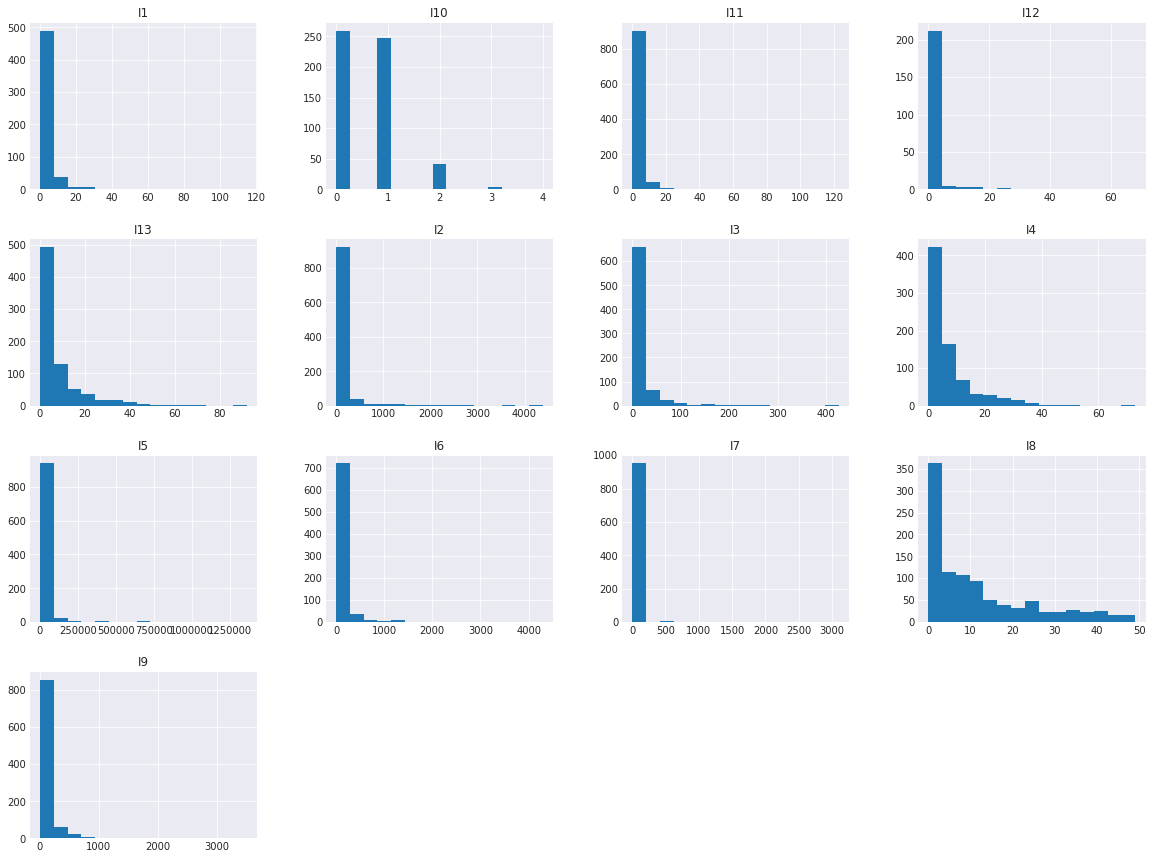

In [97]:
# part b - Take a look at histograms for each feature 
sample_numeric.hist(figsize=(20,15), bins=15)
plt.show()

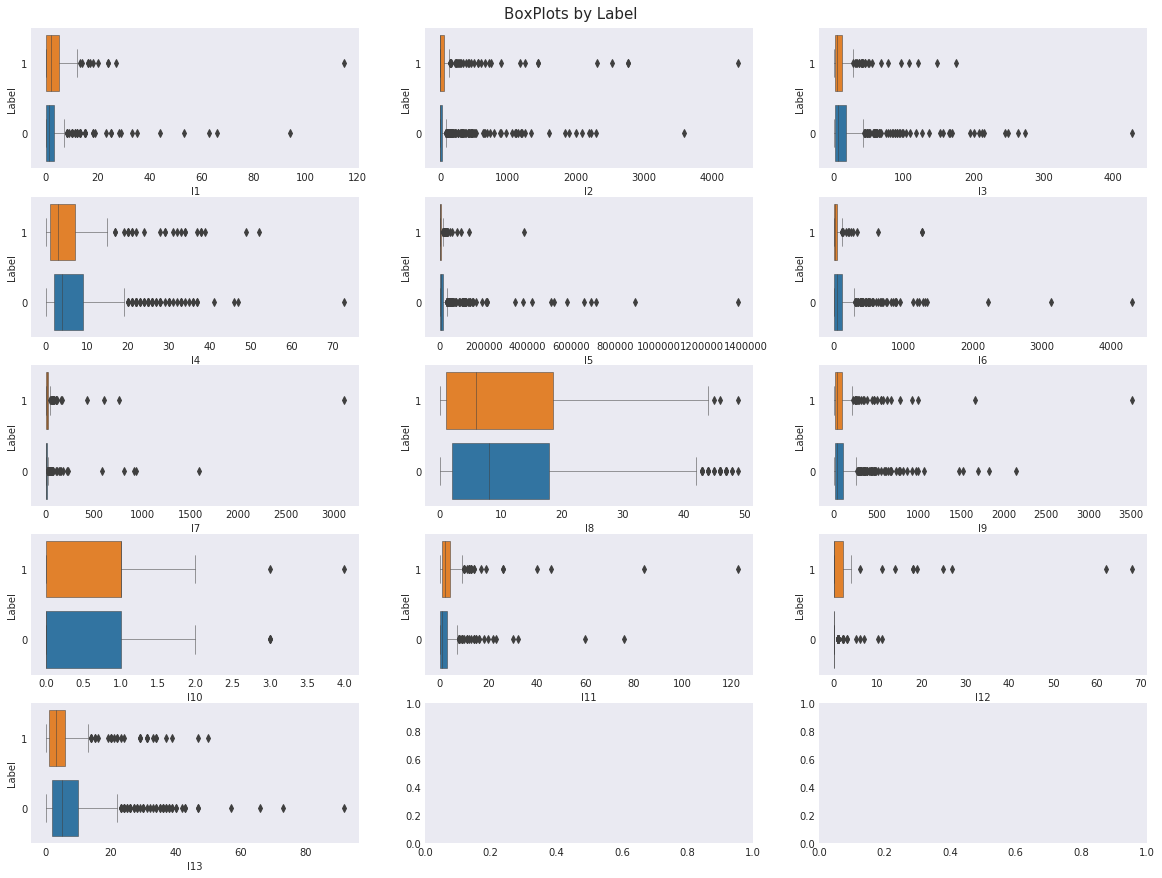

In [145]:
# part c -  plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(5, 3, figsize=(20,15))
y = sample_df['Label']
for idx, feature in enumerate(NUM_FIELDS):
    x = sample_numeric[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

#### F. Sample Dataset - Categorical Numerical Features

In [104]:
# part a - Look at summary statistics of categorical columns (includes label column)
sample_df.describe(exclude = [np.number])

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,49,203,782,660,23,7,705,39,2,602,...,390,141,4,734,6,12,477,27,360,2
top,05db9164,38a947a1,nan,nan,25c83c98,7e0ccccf,468a0854,0b153874,a73ee510,3b08e48b,...,e88ffc9d,nan,nan,nan,nan,32c7478e,3fdb382b,nan,nan,0
freq,471,109,34,34,675,380,12,576,898,228,...,37,427,427,34,767,440,54,427,427,749


#### G. Sample Dataset - Correlation between numerical features

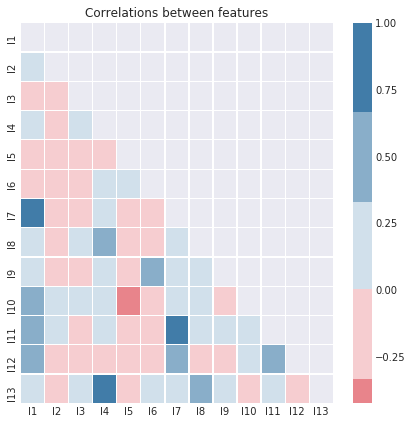

In [118]:
corr = sample_numeric.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

## ANALYSIS ON ENTIRE TRAIN DATASET USING DATAFRAMES

#### Imports

In [14]:
# Imports for DF and MLIB
import pyspark.sql.functions as func
from pyspark.sql.functions import col, countDistinct, approxCountDistinct, count, when, desc
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import DataFrameStatFunctions as statFunc

# Get categorical columns most frequently occuring values
NUM_FIELDS = FIELDS[0:13]
CAT_FIELDS = list(set(FIELDS)-set(NUM_FIELDS))

#### Creating a dataframe for Sample RDD from above

In [26]:
# IF USING SAMPLE AS A RDD
sampleRDD = sc.parallelize(sample)
sampleDF = sampleRDD.map(lambda x: x.tolist()).toDF(FIELDS)

# Converting Columns to Numeric Type
for col_name in NUM_FIELDS:
    sampleDF = sampleDF.withColumn(col_name, col(col_name).cast('float'))
sampleDF = sampleDF.withColumn("Label", col("Label").cast('float'))

# Show col types and top row
sampleDF = sampleDF.cache()
print(sampleDF.dtypes)
sampleDF.head(1)

[('I1', 'float'), ('I2', 'float'), ('I3', 'float'), ('I4', 'float'), ('I5', 'float'), ('I6', 'float'), ('I7', 'float'), ('I8', 'float'), ('I9', 'float'), ('I10', 'float'), ('I11', 'float'), ('I12', 'float'), ('I13', 'float'), ('C1', 'string'), ('C2', 'string'), ('C3', 'string'), ('C4', 'string'), ('C5', 'string'), ('C6', 'string'), ('C7', 'string'), ('C8', 'string'), ('C9', 'string'), ('C10', 'string'), ('C11', 'string'), ('C12', 'string'), ('C13', 'string'), ('C14', 'string'), ('C15', 'string'), ('C16', 'string'), ('C17', 'string'), ('C18', 'string'), ('C19', 'string'), ('C20', 'string'), ('C21', 'string'), ('C22', 'string'), ('C23', 'string'), ('C24', 'string'), ('C25', 'string'), ('C26', 'string'), ('Label', 'float')]


[Row(I1=0.0, I2=0.0, I3=5.0, I4=None, I5=21911.0, I6=None, I7=None, I8=1.0, I9=None, I10=0.0, I11=None, I12=None, I13=None, C1='05db9164', C2='90081f33', C3='36e97f3a', C4='e96617b3', C5='25c83c98', C6='7e0ccccf', C7='7f2c5a6e', C8='0b153874', C9='a73ee510', C10='bbaa2887', C11='d21494f8', C12='ba5aae2e', C13='f47f13e4', C14='64c94865', C15='98995c3b', C16='23b497d2', C17='1e88c74f', C18='7181ccc8', C19='nan', C20='nan', C21='36a4f6c3', C22='ad3062eb', C23='32c7478e', C24='3e022f4d', C25='nan', C26='nan', Label=0.0)]

#### Creating a dataframe for Train RDD from above

In [19]:
sampleDF = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).map(lambda x: x.tolist()).toDF(FIELDS).cache()
                                                                   
# Converting Columns to Numeric Type
for col_name in NUM_FIELDS:
    sampleDF = sampleDF.withColumn(col_name, col(col_name).cast('float'))
sampleDF = sampleDF.withColumn("Label", col("Label").cast('int')).cache()

# Show col types and top row
print(sampleDF.dtypes)
sampleDF.head(1)

[('I1', 'float'), ('I2', 'float'), ('I3', 'float'), ('I4', 'float'), ('I5', 'float'), ('I6', 'float'), ('I7', 'float'), ('I8', 'float'), ('I9', 'float'), ('I10', 'float'), ('I11', 'float'), ('I12', 'float'), ('I13', 'float'), ('C1', 'string'), ('C2', 'string'), ('C3', 'string'), ('C4', 'string'), ('C5', 'string'), ('C6', 'string'), ('C7', 'string'), ('C8', 'string'), ('C9', 'string'), ('C10', 'string'), ('C11', 'string'), ('C12', 'string'), ('C13', 'string'), ('C14', 'string'), ('C15', 'string'), ('C16', 'string'), ('C17', 'string'), ('C18', 'string'), ('C19', 'string'), ('C20', 'string'), ('C21', 'string'), ('C22', 'string'), ('C23', 'string'), ('C24', 'string'), ('C25', 'string'), ('C26', 'string'), ('Label', 'int')]


[Row(I1=1.0, I2=1.0, I3=5.0, I4=0.0, I5=1382.0, I6=4.0, I7=15.0, I8=2.0, I9=181.0, I10=1.0, I11=2.0, I12=None, I13=2.0, C1='68fd1e64', C2='80e26c9b', C3='fb936136', C4='7b4723c4', C5='25c83c98', C6='7e0ccccf', C7='de7995b8', C8='1f89b562', C9='a73ee510', C10='a8cd5504', C11='b2cb9c98', C12='37c9c164', C13='2824a5f6', C14='1adce6ef', C15='8ba8b39a', C16='891b62e7', C17='e5ba7672', C18='f54016b9', C19='21ddcdc9', C20='b1252a9d', C21='07b5194c', C22='nan', C23='3a171ecb', C24='c5c50484', C25='e8b83407', C26='9727dd16', Label=0)]

#### Get missing fields, distinct features count and high/medium frequency features

In [54]:
high_features = dict()
medium_features =  dict()

for field in CAT_FIELDS:
    print("\nFOR COLUMN "+field+":")
    
    columnDF = sampleDF[[field]].cache()
    
    #Count of missing 
    missing_count = columnDF.select(count(when(col(field) == "nan", 1))).head()[0]
    print("No. of Missing Values:", missing_count)
    
    # Distinct
    distinct = columnDF.agg(approxCountDistinct(col(field)).alias(field)).head()[0]
    if missing_count != 0:
        distinct = distinct -1
    print("No. of Distinct Features (without nan):", distinct)
    
    # Frequent Items 
    freq10 = columnDF.stat.freqItems([field], 0.1).head()[0]
    freq5 = columnDF.stat.freqItems([field], 0.05).head()[0]
    freq5 = list(set(freq5) - set(freq10))
    print("10% Occuring Features:", freq10)
    print("5% Occuring Features:", freq5)
    
    high_features[field] = freq10
    medium_features[field] =  freq5


FOR COLUMN C1:
No. of Missing Values: 0
No. of Distinct Features (without nan): 1513
10% Occuring Features: ['be589b51', '87552397', '8cf07265', '05db9164', 'f473b8dc', '68fd1e64', '5a9ed9b0', '5bfa8ab5']
5% Occuring Features: ['241546e0', '09ca0b81', '291b7ba2', 'ae82ea21', '17f69355', '75ac2fe6', '9a89b36c', 'e8ef605b', '39af2607']

FOR COLUMN C4:
No. of Missing Values: 1248181
No. of Distinct Features (without nan): 1835689
10% Occuring Features: ['7b7cd677', '36722301', '85dd697c', '61479518']
5% Occuring Features: ['nan', '44d2b072', '974c2ef9', 'f922efad', '29998ed1', '10ee14f5', 'c18be181', '8bea9951', 'd16679b9']

FOR COLUMN C14:
No. of Missing Values: 0
No. of Distinct Features (without nan): 28
10% Occuring Features: ['64c94865', 'b28479f6', '07d13a8f', '1adce6ef', '32813e21', 'f862f261', 'cfef1c29', '051219e6', 'd2dfe871', '8ceecbc8']
5% Occuring Features: ['91233270', 'ab7390e9', 'f7c1b33f', '243a4e68', '687dfaf4', '0601d3b5', 'ad1cc976', 'cf1fc48d', 'dcd762ee', '26ac7cf4'

10% Occuring Features: ['55dd3565', 'c7dc6720', '3a171ecb', '32c7478e', 'be7c41b4', 'c3dc6cef', '423fab69', 'bcdee96c', '93bad2c0', 'dbb486d7']
5% Occuring Features: ['003cc7f4', '25e3c76b', '85d5a995', 'b264a060', '72592995']


#### Output a pickle file with features

In [87]:
with open(r"highfeatures.pickle", "wb") as output_file:
    pickle.dump(high_features, output_file)
with open(r"mediumfeatures.pickle", "wb") as output_file:
    pickle.dump(medium_features, output_file)

#### Check that the pickle files have been created successfully

In [88]:
with open(r"highfeatures.pickle","rb") as input_file:
    e = pickle.load(input_file)
print(e)
with open(r"mediumfeatures.pickle","rb") as input_file:
    f = pickle.load(input_file)
print(f)

{'C1': ['be589b51', '87552397', '8cf07265', '05db9164', 'f473b8dc', '68fd1e64', '5a9ed9b0', '5bfa8ab5'], 'C4': ['7b7cd677', '36722301', '85dd697c', '61479518'], 'C14': ['64c94865', 'b28479f6', '07d13a8f', '1adce6ef', '32813e21', 'f862f261', 'cfef1c29', '051219e6', 'd2dfe871', '8ceecbc8'], 'C18': ['5aed7436', 'f54016b9', '5bb2ec8e', '891589e7', '3987fb8a', 'e88ffc9d', '9880032b'], 'C24': ['52c59e65', 'b34f3128', '3b183c5c', 'a6e7d8d3', 'a9a2ac1a', '3fdb382b', '1793a828', 'd16bdc4c', 'aee52b6f', '31925a5b'], 'C17': ['af5d780c', '2005abd1', 'd4bb7bd8', '07c540c4', '776ce399', '1e88c74f', '27c07bd6', '8efede7f', 'e5ba7672', '3486227d'], 'C13': ['b55434a9', '1cc9ac51', 'dc154463', 'f0f0e3cf'], 'Label': [1, 0], 'C2': ['38a947a1', '287130e0', '1cfdf714', '09e68b86', '80e26c9b', '207b2d81', '8ab240be', '89ddfee8', '0468d672', '404660bb'], 'C22': ['ccfd4002', '8651fddb', '28f45308', 'nan', 'c0061c6d', 'c9d4222a', '49e825c5', '8ec974f4', '78e2e389', 'ad3062eb'], 'C12': ['9f32b866', 'dfbb09fb', '

#### Get Numerical Features Summary Stats

In [20]:
# Get numeric features summary stats
numeric_DF = sampleDF[[NUM_FIELDS]].cache()
numeric_summaryDF= numeric_DF.describe()

# Round numeric summary stats
for field in NUM_FIELDS:
    numeric_summaryDF = numeric_summaryDF.withColumn(field, func.round(numeric_summaryDF[field], 2))

# Display numeric summary stats
numeric_summaryDF[['summary']+NUM_FIELDS[0:7]].show()
numeric_summaryDF[[NUM_FIELDS[7:]]].show()

+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|summary|        I1|         I2|         I3|         I4|         I5|         I6|         I7|
+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|  count|2.003638E7|3.6668031E7|2.8798323E7|2.8720329E7|3.5721211E7|2.8468498E7|3.5082452E7|
|   mean|       3.5|     105.88|      26.88|       7.32|   18541.85|     116.08|      16.34|
| stddev|       9.4|     391.96|     396.17|       8.79|   69327.05|     380.42|      66.39|
|    min|       0.0|       -3.0|        0.0|        0.0|        0.0|        0.0|        0.0|
|    max|    5775.0|   257675.0|    65535.0|      969.0|  2693697.0|   430898.0|    56311.0|
+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+

+-----------+-----------+----------+-----------+---------+-----------+
|         I8|         I9|       I10|        I11|      I12|        I13|
+-----------+-------

#### Column Quantiles to do bucketing later  Note: values are [min, 25%, median, 75%, max]

In [52]:
splits = []

# Round numeric summary stats
for field in NUM_FIELDS:
    split = set(statFunc(sampleDF).approxQuantile(field, probabilities = [0.0,0.25,0.50,0.75,1.0], relativeError=0.2))
    splits.append(sorted(list(split)))

print("Column Quantiles:\n")
print(splits)

Column Quantiles:

[[0.0, 1.0, 2.0, 683.0, 5775.0], [-3.0, 8.0, 9.0, 14866.0, 257675.0], [0.0, 9.0, 10.0, 37675.0, 65535.0], [0.0, 6.0, 355.0, 969.0], [0.0, 5456.0, 2223410.0, 2417777.0, 2693697.0], [0.0, 49.0, 27776.0, 430898.0], [0.0, 2.0, 6.0, 11103.0, 56311.0], [0.0, 5.0, 12.0, 6047.0], [0.0, 56.0, 9154.0, 25618.0], [0.0, 1.0, 7.0, 10.0], [0.0, 2.0, 131.0, 231.0], [0.0, 190.0, 376.0, 4008.0], [0.0, 3.0, 7.0, 2540.0, 7393.0]]


#### Bucket each numerical column based on features and get counts for each bucket

In [27]:
count_buckets = []
buckets = []

for i,field in enumerate(NUM_FIELDS):
    if len(splits[i])==2:
        splits[i] = [-float("inf")] + splits[i] + [float("inf")]
        
    # Bucketize the values
    bucketizer = Bucketizer(handleInvalid = 'skip', splits = splits[i], inputCol=field, outputCol="bucket")
    result = bucketizer.transform(sampleDF[[field]]).cache()
    print("\nFOR COLUMN "+field+":", "splits are:", splits[i])
    
    # Get ccount of each bucket in a column
    bucket = result.groupBy(["bucket"]).agg(count("bucket").alias("count")).orderBy("bucket")
    count_buckets.append([value[1] for value in bucket.collect()])
    buckets.append([value[0] for value in bucket.collect()])
    print(bucket.show())
    
print("Buckets:", buckets)
print("Bucket Counts:", count_buckets)


FOR COLUMN I1: splits are: [0.0, 2.0, 479.0, 546.0, 5775.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|12024185|
|   1.0| 8012001|
|   2.0|      55|
|   3.0|     139|
+------+--------+

None

FOR COLUMN I2: splits are: [-3.0, 8.0, 13458.0, 16041.0, 257675.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|21565390|
|   1.0|15102502|
|   2.0|      88|
|   3.0|      51|
+------+--------+

None

FOR COLUMN I3: splits are: [0.0, 5.0, 37675.0, 65535.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|12067136|
|   1.0|16730818|
|   2.0|     369|
+------+--------+

None

FOR COLUMN I4: splits are: [0.0, 6.0, 267.0, 388.0, 969.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|16836436|
|   1.0|11883557|
|   2.0|     203|
|   3.0|     133|
+------+--------+

None

FOR COLUMN I5: splits are: [0.0, 4671.0, 5456.0, 2513122.0, 2693697.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|21612474|
|   1.0|  657177|
|   2.0|13

#### Visualize each of the bucketed numerical column 
Note: if values are too low, they are not shown in the plot. Look at split values in title to determine which values are a minority/outliers

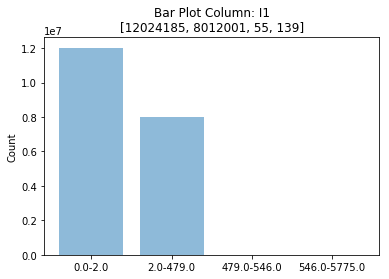

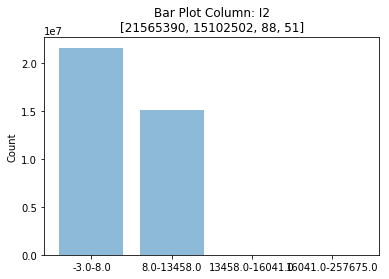

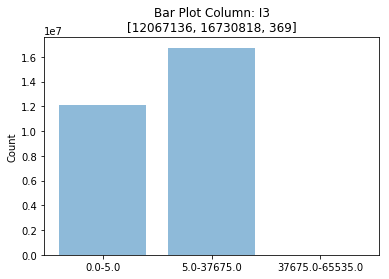

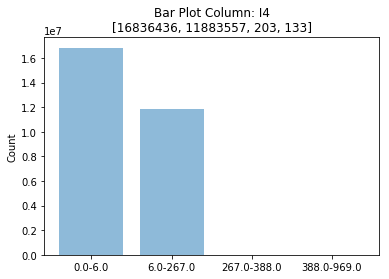

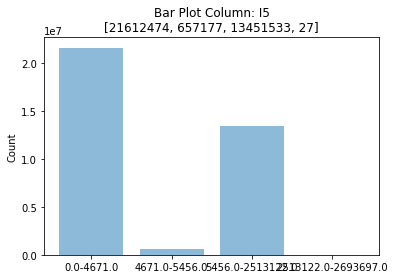

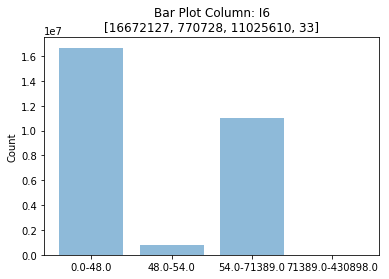

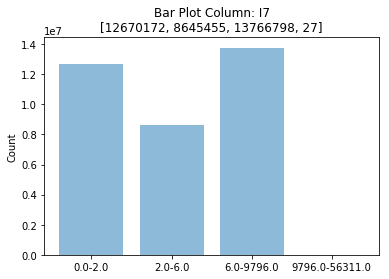

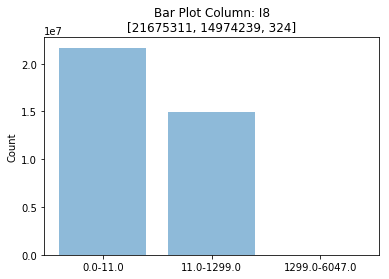

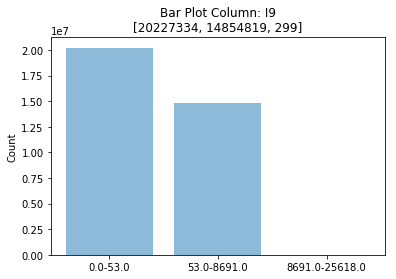

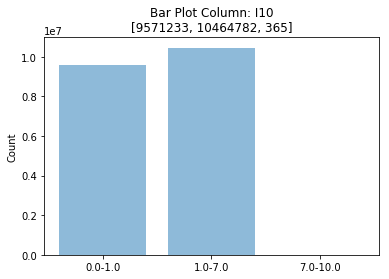

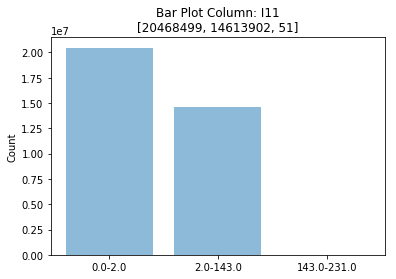

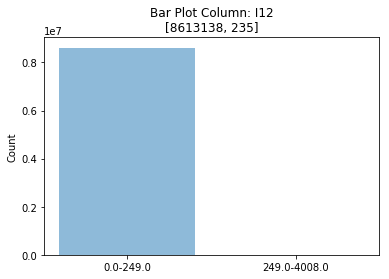

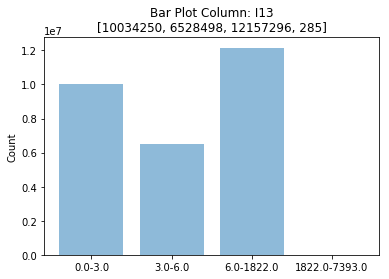

In [49]:
for j, field in enumerate(NUM_FIELDS):
    N = len(buckets[j])
    index = np.arange(N)
    bar_width = 0.95
    labels = []

    for i in range(N):
        labels.append(str(splits[j][i]) + "-" + str(splits[j][i+1]))

    plt.bar(buckets[j], count_buckets[j], align='center', alpha=0.5)
    plt.ylabel('Count')
    plt.xticks(index, labels)   
    plt.title('Bar Plot Column: ' + field + '\n'+str(count_buckets[j]))
plt.show()

### EDA

#### Dataset Introduction 

The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26 categorical features. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed. Some features may have missing values.

The rows are chronologically ordered. The test set is computed in the same way as the training set but it 
corresponds to events on the day following the training period and does not have the label column.

#### Train File:

* Number of rows: 45840617 (~ 45 million)
2. Number of columns: 40 Columns
    -  13 Numerical Features I1-I13
    -  26 Categorical Features C1-C26
    -  1 Label Column - 0 or 1  
3. **Numerical Columns Analysis**:
4. **Categorical Columns Analysis**:
5. **Output Column Analysis**:
    -  Binary variable with values as 0 or 1 
    -  0 - user clicked on the ad, 1 - user did not click on the ad

#### Test File:

1. Number of rows: 6042135 (~ 6 million)
2. Number of columns: 
3. Numerical Columns Analysis:
4. Categorical Columns Analysis:
5. Output Column Analysis:
    

## 4. Algorithm Implementation

## 5. Application of Course Concepts